In [1]:
######
# ! Warning: this class is probably not up to date

#### Imports
import os
import numpy as np
import yaml
import json
import sys
import importlib
import pickle
import xtrack as xt
import xmask as xm
import xmask.lhc as xlhc


#### Build collider class
class BuildCollider:
    def __init__(self, path_configuration, save_collider_before_bb=True):
        """Initialize the BuildCollider class."""

        # Configuration path
        self.path_configuration = path_configuration

        # Load configuration
        self.configuration = self.load_configuration()

        # Correct path in configuration
        self.correct_configuration()

        # Load and tune collider
        self.collider, self.collider_before_bb = self.load_and_tune_collider(
            save_collider_before_bb
        )
        
        # Build trackers for collider_before_bb
        if self.collider_before_bb is not None:
            self.collider_before_bb.build_trackers()

    def load_configuration(self):
        """Loads the configuration from a yaml file."""
        with open(self.path_configuration, "r") as fid:
            configuration = yaml.safe_load(fid)
        return configuration

    def correct_configuration(self):
        """Corrects the paths in the configuration file (from relative to absolute)."""
        self.configuration["config_simulation"]["collider_file"] = (
            self.path_configuration.split("config.yaml")[0]
            + self.configuration["config_simulation"]["collider_file"]
        )

        # ? Correction of the configuration files is not required anymore as they're produced locally
        # for lhcb in ["lhcb1", "lhcb2"]:
        #     self.configuration["config_collider"]["config_knobs_and_tuning"][
        #         "closed_orbit_correction"
        #     ][lhcb] = (
        #         self.path_configuration.split("config.yaml")[0]
        #         + self.configuration["config_collider"]["config_knobs_and_tuning"][
        #             "closed_orbit_correction"
        #         ][lhcb]
        #     )

    def load_and_tune_collider(self, save_collider_before_bb):
        """Build the collider using the same script as in the initial configuration file."""

        # Path of the 2_configure_and_track file
        path_configure_and_track = self.path_configuration.split("config.yaml")[0]
        name_module = "2_configure_and_track.py"
        # Check that the twiss and track file exists
        if not os.path.exists(path_configure_and_track + name_module):
            raise ValueError(
                "The 2_configure_and_track file does not exist in the same directory as the config"
                " file. No collider can be built ensuring reproducibility."
            )
        else:
            # Add to sys
            sys.path.insert(1, path_configure_and_track)

            # Import the module
            configure_and_track = importlib.import_module("2_configure_and_track")

        # Build collider
        if save_collider_before_bb:
            collider, _, collider_before_bb = configure_and_track.configure_collider(
                self.configuration["config_simulation"],
                self.configuration["config_collider"],
                save_collider=False,
                return_collider_before_bb=save_collider_before_bb,
            )
        else:
            collider, _ = configure_and_track.configure_collider(
                self.configuration["config_simulation"],
                self.configuration["config_collider"],
                save_collider=False,
                return_collider_before_bb=save_collider_before_bb,
            )
            collider_before_bb = None

        # Remove the folder "correction" which was created during the process
        os.system("rm -rf correction")
        # Remove other temporary files
        os.system("rm -rf .__*")

        return collider, collider_before_bb

    def dump_collider(self, prefix=None, suffix="collider.json", dump_before_bb=False):
        """Dumps the collider to a json file."""
        path_collider = (
            self.path_configuration.split("/scans/")[1]
            .split("config.yaml")[0]
            .replace("/", "_")[:-5]
        )
        if prefix is not None:
            path_collider = prefix + path_collider + suffix
        self.collider.to_json(path_collider)

        if self.collider_before_bb is not None and dump_before_bb:
            path_collider_before_bb = path_collider.replace(".json", "_before_bb.json")
            self.collider_before_bb.to_json(path_collider_before_bb)
            return path_collider, path_collider_before_bb
        elif self.collider_before_bb is None and dump_before_bb:
            raise ValueError("No collider before beam-beam has been provided.")
        else:
            return path_collider

In [36]:
# Standard imports
import pandas as pd
import sys 
import os
import seaborn as sns
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
#sns.set(font='Adobe Devanagari')
sns.set_context("paper", font_scale=0.8, rc={"lines.linewidth": 0.5, "grid.linewidth": 0.3})


matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
# Not italized latex
matplotlib.rcParams['mathtext.default'] = 'regular'
matplotlib.rcParams["font.weight"] = "light"

%config InlineBackend.figure_format='svg'

In [2]:
# Build collider with chroma 15, eol
path_config_15 = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/opt_flathv_75_1500_withBB_chroma15_eol_bbb_2228/base_collider/xtrack_0000/config.yaml"
build_collider_15 = BuildCollider(path_config_15, save_collider_before_bb=False)

path_config_5 = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/scans/opt_flathv_75_1500_withBB_chroma5_eol_tune_tune_2228/base_collider/xtrack_0734/config.yaml"
build_collider_5 = BuildCollider(path_config_5, save_collider_before_bb=False)


Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


KeyboardInterrupt: 

In [38]:
collider_15 = build_collider_15.collider
collider_5 = build_collider_5.collider


In [39]:
fname = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/master_jobs/filling_scheme/25ns_2228b_2216_1686_2112_hybrid_8b4e_2x56b_25ns_3x48b_12inj_with_identical_bunches.json"
with open(fname, "r") as fid:
    filling = json.load(fid)
filling_pattern_cw = filling["beam1"]
filling_pattern_acw = filling["beam2"]


In [40]:
b2 = np.nonzero(filling_pattern_acw)[0][0]
b2

12

In [41]:
l_b = []
l_qx15 = []
l_dqx15 = []
l_qx5 = []
l_dqx5 = []
l_qy5 = []
l_dqy5 = []
l_qy15 = []
l_dqy15 = []
b2 = np.nonzero(filling_pattern_acw)[0][0]
for idx, b in enumerate(filling_pattern_cw): 
    if b==1:
        i_bunch_cw = idx
    else:
        continue
    # Loop over bunches and get the chromaticity everytime
    collider_15.apply_filling_pattern(
        filling_pattern_cw=filling_pattern_cw,
        filling_pattern_acw=filling_pattern_acw,
        i_bunch_cw=i_bunch_cw,
        i_bunch_acw=b2,
    )
    collider_5.apply_filling_pattern(
        filling_pattern_cw=filling_pattern_cw,
        filling_pattern_acw=filling_pattern_acw,
        i_bunch_cw=i_bunch_cw,
        i_bunch_acw=b2,
    )
    
    tw_15 = collider_15.lhcb1.twiss()
    tunex_15 = tw_15.qx
    tuney_15 = tw_15.qy
    chromax_15 = tw_15.dqx
    chromay_15 = tw_15.dqy
    tw_5 = collider_5.lhcb1.twiss()
    tunex_5 = tw_5.qx
    tuney_5 = tw_5.qy
    chromax_5 = tw_5.dqx
    chromay_5 = tw_5.dqy
    
    l_b.append(idx)
    l_qx15.append(tunex_15)
    l_qy15.append(tuney_15)
    l_dqx15.append(chromax_15)
    l_dqy15.append(chromay_15)
    l_qx5.append(tunex_5)
    l_qy5.append(tuney_5)
    l_dqx5.append(chromax_5)
    l_dqy5.append(chromay_5)


In [ ]:
# Get beam-beam schedule
import fillingpatterns as fp
path_filling_scheme = "/afs/cern.ch/work/c/cdroin/private/example_DA_study/master_study/master_jobs/filling_scheme/25ns_2228b_2216_1686_2112_hybrid_8b4e_2x56b_25ns_3x48b_12inj.json"

patt = fp.FillingPattern.from_json(path_filling_scheme)
patt.compute_beam_beam_schedule(n_lr_per_side=26)

sched_b1 = patt.b1.bb_schedule

# Get bunch that do not collider in lhcb
sched_b1_no_lhcb = sched_b1[sched_b1['collides in LHCB'] == False]

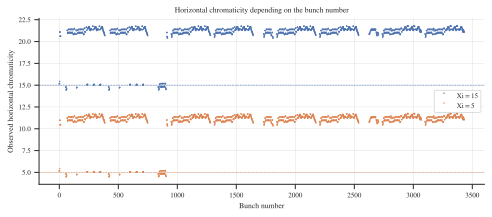

In [78]:
from matplotlib.legend_handler import HandlerLine2D

def update_prop(handle, orig):
    handle.update_from(orig)
    x,y = handle.get_data()
    handle.set_data([np.mean(x)]*2, [0, 2*y[0]])
    

plt.figure(figsize=(8, 3))
plt.plot(l_b, l_dqx15, '.', label=r'$Xi = 15$', color='C0', markersize = 1)
plt.plot(l_b, l_dqx5, '.', label=r'$Xi = 5$', color='C1', markersize = 1)
plt.axhline(15,  linestyle='--',  color='C0')
plt.axhline(5,  linestyle='--',  color='C1')
# for x in sched_b1_no_lhcb.index:
#     if x==0:
#         plt.axvline(x, color='C2', alpha=0.5, linewidth=0.5, label='No collision in LHCb')
#     else:
#         plt.axvline(x, color='C2', alpha=0.5, linestyle='--', linewidth=0.2)
plt.title('Horizontal chromaticity depending on the bunch number')
plt.xlabel('Bunch number')
plt.ylabel('Observed horizontal chromaticity')
plt.legend(handler_map={plt.Line2D:HandlerLine2D(update_func=update_prop)})
plt.grid()
plt.savefig('bbb_chromax_init.pdf', bbox_inches='tight')
plt.show()

Computing collision schedules...
Done Beam 1
Done Beam 2


,HO partner in ALICE,# of LR in ALICE,BB partners in ALICE,Positions in ALICE,HO partner in ATLAS/CMS,# of LR in ATLAS/CMS,BB partners in ATLAS/CMS,Positions in ATLAS/CMS,HO partner in LHCB,# of LR in LHCB,BB partners in LHCB,Positions in LHCB,collides in ATLAS/CMS,collides in ALICE,collides in LHCB
0,891.0,36,"[865.0, 866.0, 867.0, 868.0, 869.0, 874.0, 875...","[-26.0, -25.0, -24.0, -23.0, -22.0, -17.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....",NaN,34,"[2644.0, 2645.0, 2650.0, 2651.0, 2652.0, 2653....","[-26.0, -25.0, -20.0, -19.0, -18.0, -17.0, -16...",False,True,False
1,892.0,35,"[866.0, 867.0, 868.0, 869.0, 874.0, 875.0, 876...","[-26.0, -25.0, -24.0, -23.0, -18.0, -17.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18....",NaN,33,"[2645.0, 2650.0, 2651.0, 2652.0, 2653.0, 2654....","[-26.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16...",False,True,False
2,893.0,34,"[867.0, 868.0, 869.0, 874.0, 875.0, 876.0, 877...","[-26.0, -25.0, -24.0, -19.0, -18.0, -17.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17....",NaN,33,"[2650.0, 2651.0, 2652.0, 2653.0, 2654.0, 2655....","[-22.0, -21.0, -20.0, -19.0, -18.0, -17.0, -16...",False,True,False
3,NaN,34,"[868.0, 869.0, 874.0, 875.0, 876.0, 877.0, 878...","[-26.0, -25.0, -20.0, -19.0, -18.0, -17.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0...",NaN,34,"[2650.0, 2651.0, 2652.0, 2653.0, 2654.0, 2655....","[-23.0, -22.0, -21.0, -20.0, -19.0, -18.0, -17...",False,False,False
55,NaN,16,"[949.0, 950.0, 951.0, 952.0, 953.0, 954.0, 955...","[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0...",55.0,18,"[55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62....","[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 12.0,...",NaN,18,"[2699.0, 2700.0, 2701.0, 2702.0, 2703.0, 2704....","[-26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20...",True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,1792.0,31,"[1768.0, 1769.0, 1770.0, 1771.0, 1772.0, 1773....","[-24.0, -23.0, -22.0, -21.0, -20.0, -19.0, -18...",901.0,30,"[875.0, 876.0, 877.0, 878.0, 879.0, 880.0, 881...","[-26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13...",True,True,False
902,1793.0,31,"[1768.0, 1769.0, 1770.0, 1771.0, 1772.0, 1773....","[-25.0, -24.0, -23.0, -22.0, -21.0, -20.0, -19...",902.0,29,"[876.0, 877.0, 878.0, 879.0, 880.0, 881.0, 886...","[-26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12....",True,True,False
903,1794.0,31,"[1768.0, 1769.0, 1770.0, 1771.0, 1772.0, 1773....","[-26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20...",903.0,28,"[877.0, 878.0, 879.0, 880.0, 881.0, 886.0, 887...","[-26.0, -25.0, -24.0, -23.0, -22.0, -17.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0...",True,True,False
904,1795.0,30,"[1769.0, 1770.0, 1771.0, 1772.0, 1773.0, 1774....","[-26.0, -25.0, -24.0, -23.0, -22.0, -21.0, -20...",904.0,27,"[878.0, 879.0, 880.0, 881.0, 886.0, 887.0, 888...","[-26.0, -25.0, -24.0, -23.0, -18.0, -17.0, -16...",NaN,12,"[12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19....","[2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0,...",True,True,False


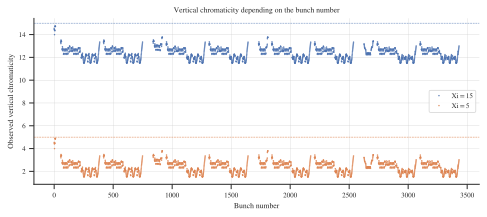

In [72]:
plt.figure(figsize=(8, 3))
plt.plot(l_b, l_dqy15, '.', label=r'$Xi = 15$', color='C0', markersize = 1)
plt.plot(l_b, l_dqy5, '.', label=r'$Xi = 5$', color='C1', markersize = 1)
plt.axhline(15,  linestyle='--',  color='C0')
plt.axhline(5,  linestyle='--',  color='C1')
plt.title('Vertical chromaticity depending on the bunch number')
plt.xlabel('Bunch number')
plt.ylabel('Observed vertical chromaticity')
plt.legend()
plt.grid()
plt.savefig('bbb_chromay.pdf', bbox_inches='tight')
plt.show()

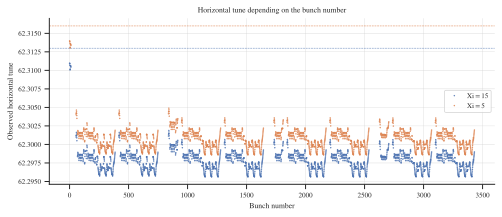

In [73]:
plt.figure(figsize=(8, 3))
plt.plot(l_b, l_qx15, '.', label=r'$Xi=15$', color='C0', markersize = 1)
plt.plot(l_b, l_qx5, '.', label=r'$Xi=5$', color='C1', markersize = 1)
plt.axhline(62.313,  linestyle='--',  color='C0')
plt.axhline(62.316,  linestyle='--',  color='C1')
plt.title('Horizontal tune depending on the bunch number')
plt.xlabel('Bunch number')
plt.ylabel('Observed horizontal tune')
plt.legend()
plt.grid()
plt.savefig('bbb_tunex.pdf', bbox_inches='tight')
plt.show()

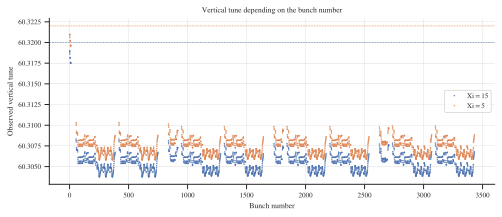

In [74]:
plt.figure(figsize=(8, 3))
plt.plot(l_b, l_qy15, '.', label=r'$Xi=15$', color='C0', markersize = 1)
plt.plot(l_b, l_qy5, '.', label=r'$Xi=5$', color='C1', markersize = 1)
plt.axhline(60.320,  linestyle='--', color='C0')
plt.axhline(60.322,  linestyle='--', color='C1')
plt.title('Vertical tune depending on the bunch number')
plt.xlabel('Bunch number')
plt.ylabel('Observed vertical tune')
plt.legend()
plt.grid()
plt.savefig('bbb_tuney.pdf', bbox_inches='tight')
plt.show()

In [75]:
tw_5.rows[f"ip{2}"].cols["s", "x", "px", "y", "py", "betx", "bety", "dx", "dy"].to_pandas()


,name,s,x,px,y,py,betx,bety,dx,dy
0,ip2,23326.598984,-0.000146,2.239108e-07,-8.339203e-08,-0.0001,9.434471,8.981812,-0.111,-0.01743


In [76]:
tw_5.rows[f"ip{8}"].cols["s", "x", "px", "y", "py", "betx", "bety", "dx", "dy"].to_pandas()


,name,s,x,px,y,py,betx,bety,dx,dy
0,ip8,16650.658184,-0.000017,0.000135,0.000014,0.000172,1.351462,1.393097,-0.06798,-0.008517


In [77]:
tw_5.rows[f"ip{1}"].cols["s", "x", "px", "y", "py", "betx", "bety", "dx", "dy"].to_pandas()


,name,s,x,px,y,py,betx,bety,dx,dy
0,ip1,19994.1624,-9.057189e-08,0.00025,-1.162936e-08,2.658606e-07,0.167982,0.070532,-0.020196,-0.003091
